This notebook accompanies the contribution "1000 Punkte für Goethe. Eine empirische Rekonstruktion des Kanons der neueren deutschsprachigen Literatur".

# Preparation

## Import

In [1]:
# import packages
import pandas as pd
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import ruptures as rpt

In [2]:
# import data file with information about all indicators.
data = pd.read_csv("../data/data.csv", index_col=[0])

In [3]:
# Create dictionaries that store information about the indicator-columns
academic_indicator_dict = {
    'unilist' : [x for x in data.columns if 'prob_to_read_share' in x],
    'litges' : [x for x in data.columns if 'page_count_rel_litges' in x],
    'vv' : [x for x in data.columns if 'event_count_rel_vv' in x],
    'lexica' : ['killy_length'],
    'editions' : ['reclam_count'],
    'bibliographies' : ['BDSL_hits_2000_all']
}

other_indicator_dict = {
    'staatsexamen' : ['staatsexamen_count'],
    'schullist' : [x for x in data.columns if 'schullist_' in x and 'share' in x],
    'abi' : ['abi_mentions'],
    'kanonspiel' : ['kanonspiel_points'],
    'segebrecht' : ['segebrecht_count'],
    'vv_hein' : ['vv_hein_count'],
    'wiki' : ['wiki_length_in_words']
}

all_indicator_dict = {**academic_indicator_dict, **other_indicator_dict}

all_indicator_label_dict = {
    'unilist' : 'Universitäre Leselisten',
    'litges' : 'Literaturgeschichten',
    'vv' : 'Universitäre Vorlesungsverzeichnisse',
    'lexica' : 'Fachlexika',
    'bibliographies' : 'Fachbibliographien',
    'editions' : 'Editionen',
    'vv_hein' : 'Vorlesungsverzeichnisse (Hein)',
    'staatsexamen' : 'Staatsexamina',
    'schullist' : 'Schulleselisten',
    'abi' : 'Abiturvorgaben',
    'wiki' : 'Online-Enzyklopädien',
    'kanonspiel' : 'Kanon-Spiel',
    'segebrecht' : 'Segebrecht'
}

In [4]:
# Statistics about indictors
print("Number of primary   indicators                         : ", len(all_indicator_dict.keys()))
print("Number of secondary indicators                         : ", \
      len([element for innerList in list(all_indicator_dict.values()) for element in innerList]))   

print("Number of primary   indicators for academic canonicity : ", len(academic_indicator_dict.keys()))
print("Number of secondary indicators for academic canonicity : ", \
      len([element for innerList in list(academic_indicator_dict.values()) for element in innerList]))      

Number of primary   indicators                         :  13
Number of secondary indicators                         :  69
Number of primary   indicators for academic canonicity :  6
Number of secondary indicators for academic canonicity :  50


## GND Filter

In [5]:
# Define relevant filters
relevant_occupations = [
    'Schriftsteller', 'Schriftstellerin', 'Dramatiker',
    'Lyriker', 'Drehbuchautor', 'Librettist',
    'Lyrikerin', 'Kirchenlieddichter',
    'Erzähler', 'Drehbuchautorin', 'Kinderbuchautor',
    'Dramatikerin', 'Librettistin', 'Liederdichter',
    'Kinderbuchautorin', 'Jugendbuchautor',
    'Minnesänger', 'Mundartschriftsteller', 'Jugendbuchautorin',
    'Musikschriftsteller', 'Romancier', 'Reiseschriftsteller',
    'Meistersinger', 'Kriminalschriftsteller', 'Liedermacher',
    'Prosaist', 'Kirchenlieddichterin', 'Prosaistin',
    'Theaterdichter', 'Heimatschriftsteller', 'Erzählerin',
    'Spruchdichter', 'Mundartschriftstellerin', 'Romanschriftstellerin',
    'Liederdichterin', 'Musikschriftstellerin',
    'Liedermacherin', 'Bilderbuchautor', 'Stadtschreiberin <Literatur>',
    'Kriminalschriftstellerin', 'Exilschriftsteller', 'Comicautorin',
    'Bestsellerautorin', 'Reiseschriftstellerin',

    'Satiriker', 'Hofdichter', 'Satirikerin',
    'Reisebuchautor',
]

relevant_countries = [
    'Deutschland',
    'Österreich',
    'Schweiz'
]

In [6]:
print("Number of people in dataset BEFORE gnd filtering : ", data.shape[0])

data = (
    data
    .query("GND_birth >= 1550")
    .loc[data['GND_occupation'].str.contains('|'.join(relevant_occupations), na=False)]
    .loc[data['GND_country'].str.contains('|'.join(relevant_countries), na=False)]
).copy()

print("Number of people in dataset AFTER  gnd filtering : ", data.shape[0])

Number of people in dataset BEFORE gnd filtering :  9628
Number of people in dataset AFTER  gnd filtering :  5209


## Manual Filter

In [7]:
entities_to_delete = [
    '118509039', # Benjamin, Walter
    '118594117', # Wagner, Richard
    '118500775', # Adorno, Theodor W.
    '118603426', # Rousseau, Jean-Jacques
    '118554727', # Humboldt, Wilhelm von
    '11862220X', # Thomasius, Christian
    '118607057', # Schelling, Friedrich Wilhelm Joseph von
    '118532847', # Fichte, Johann Gottlieb
    '118554700', # Humboldt, Alexander von
    '11850391X', # Arendt, Hannah
    '118638289', # Čechov, Anton Pavlovič
    '118627813', # Voltaire
    '118664123', # Blumenberg, Hans
    '118535749', # Friedrich II., Preußen, König
    '11574326X', # Arnold, Heinz Ludwig
    '118608045', # Schleiermacher, Friedrich
    '118525727', # Dilthey, Wilhelm
    '118599194', # Reich-Ranicki, Marcel
    '118584790', # Müller, Adam Heinrich
    '118556312', # Jacobi, Friedrich Heinrich
    '120309297', # Detering, Heinrich
    '118514881', # Breitinger, Johann Jakob
    '119090198', # Wagenseil, Johann Christoph
    '119505258', # Sepúlveda, Luis
    '118795163', # Schlosser, Johann Georg
    '118891871', # Skármeta, Antonio
    '121846067', # Illies, Florian
    '118630040', # Weidig, Friedrich Ludwig
    '118557327', # Jens, Walter
    '118631764', # Wessenberg, Ignaz Heinrich von
    '118516477', # Buber, Martin
    '11874559X', # Rochow, Friedrich Eberhard von
    '118628836', # Wallraff, Günter
    '118763784', # Unseld, Siegfried

    '118501259', # Ajtmatov, Čingiz
    '118513532', # Borges, Jorge Luis
    '118518208', # Byron, George Gordon Byron, Baron
    '118518739', # Camus, Albert
    '118519948', # Césaire, Aimé'
    '118541765', # Green, Julien
    '118555707', # Ionesco, Eugène
    '118765396', # Sillitoe, Alan
 ]

In [8]:
# Filter Entities from dataframe
print("Number of people in dataset BEFORE manual filtering : ", data.shape[0])
data = data[~data["GND"].isin(entities_to_delete)]

print("Number of people in dataset AFTER  manual filtering : ", data.shape[0])

Number of people in dataset BEFORE manual filtering :  5209
Number of people in dataset AFTER  manual filtering :  5167


# 4. Methoden

In [9]:
scaler_0_1 = MinMaxScaler(feature_range=(0, 1))
scaler_1_1000 = MinMaxScaler(feature_range=(1, 1000))

def add_scores(
        df,
        all_indicator_dict = all_indicator_dict,
        canon_indicators = academic_indicator_dict.keys(),
        method_first_norm = 'zscore',
        method_first_merge = 'median',
        method_second_norm = 'zscore',
        method_second_merge = 'median'
        ):
    
    df = df.copy()
    
    # (1) apply zscore, scaling, and rank on secondary indicators
    for primary_indicator, secondary_indicators in all_indicator_dict.items():
        for secondary_indicator in secondary_indicators:
            df[secondary_indicator+'_zscore'] = zscore(df[secondary_indicator])
            df[secondary_indicator+'_scaled'] = scaler_0_1.fit_transform(df[[secondary_indicator]])
            df[secondary_indicator+'_rank'] = df[secondary_indicator].rank(method='min', ascending=False).astype(int)
            df = df.copy()

    # (2) create score for primary indicators by calculating mean/median of secondary indicators
    for primary_indicator, secondary_indicators in all_indicator_dict.items():
        if method_first_merge == 'mean':
            df[primary_indicator] = df[[x+'_'+method_first_norm for x in secondary_indicators]].mean(axis=1)
        elif method_first_merge == 'median':
            df[primary_indicator] = df[[x+'_'+method_first_norm for x in secondary_indicators]].median(axis=1)
        else:
            print("wrong method_first_merge")
    df = df.copy()

    # (3) apply zscore, scaling, rank, and relcount on primary indicators
    for primary_indicator, secondary_indicators in all_indicator_dict.items():
        df[primary_indicator+'_zscore'] = zscore(df[primary_indicator])
        df[primary_indicator+'_scaled'] = scaler_0_1.fit_transform(df[[primary_indicator]])
        df[primary_indicator+'_rank'] = df[primary_indicator].rank(method='min', ascending=False).astype(int)
        df[primary_indicator+'_relcount'] = (df[secondary_indicators] > 0).sum(axis=1)
    df = df.copy()

    # (4) create overall canonicity score by calculating mean/median of primary indicators
    if method_second_merge == 'mean':
        df['canonicity_score_raw'] = df[[x+'_'+method_second_norm for x in canon_indicators]].mean(axis=1)
    elif method_second_merge == 'median':
        df['canonicity_score_raw'] = df[[x+'_'+method_second_norm for x in canon_indicators]].median(axis=1)
    else:
        print("wrong method_second_merge")

    # (5) apply zscore, scaling, rank, and relcount on primary indicators
    df['canonicity_score_zscore'] = zscore(df[['canonicity_score_raw']])
    df['canonicity_score_scaled'] = scaler_1_1000.fit_transform(df[['canonicity_score_raw']])
    df['canonicity_score_rank'] = df['canonicity_score_raw'].rank(method='min', ascending=False).astype(int)
    df['canonicity_score_rank_cont'] = df['canonicity_score_raw'].rank(method='first', ascending=False).astype(int)
    df['canonicity_score_relcount'] = (df[[x+'_relcount' for x in academic_indicator_dict.keys()]] > 0).sum(axis=1)

    return df

In [10]:
data = add_scores(data).copy()

## Robustness Check

top 100 authors


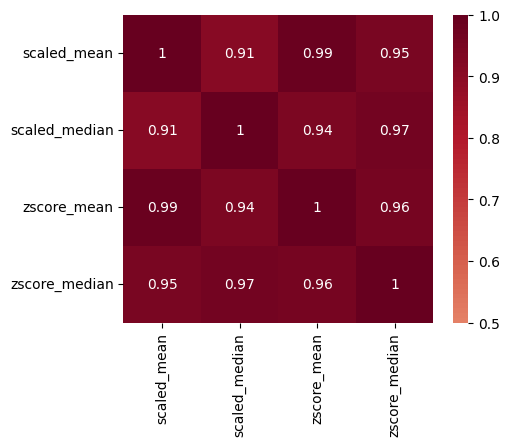

top 500 authors


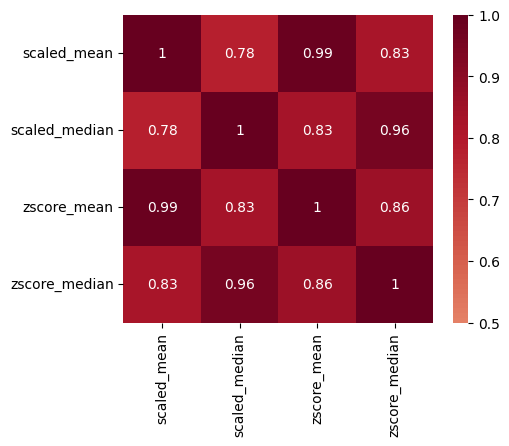

top 999999 authors


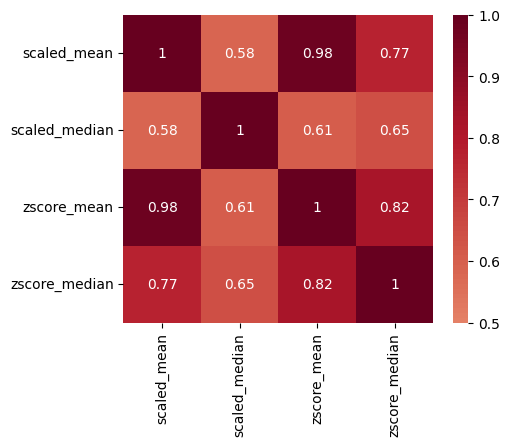

In [11]:
# min-max vs. zscore, mean vs. median

robustness_data = data[['GND_name']].copy()

for method_norm in ['scaled', 'zscore']:
    for method_merge in ['mean', 'median']:
        data_temp = add_scores(
            data,
            method_first_norm = method_norm, method_first_merge = method_merge, 
            method_second_norm = method_norm, method_second_merge = method_merge, 
            ).copy()
        robustness_data[method_norm+'_'+method_merge] = data_temp['canonicity_score_raw']
        robustness_data = robustness_data.copy()

for top in [100, 500, 999999]:
    print(f"top {top} authors")
    corr_results = robustness_data.sort_values(by='zscore_median').tail(top).drop(['GND_name'], axis=1).corr(method='spearman')

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        corr_results,
        annot=True,
        vmin=0.5, vmax=1,   # fix scale from -1 to 1
        center=0,          # optional: ensures diverging colormap is centered at 0
        cmap="RdBu_r"    # diverging colormap for negative/positive values
    )
    plt.show()

top 100 authors


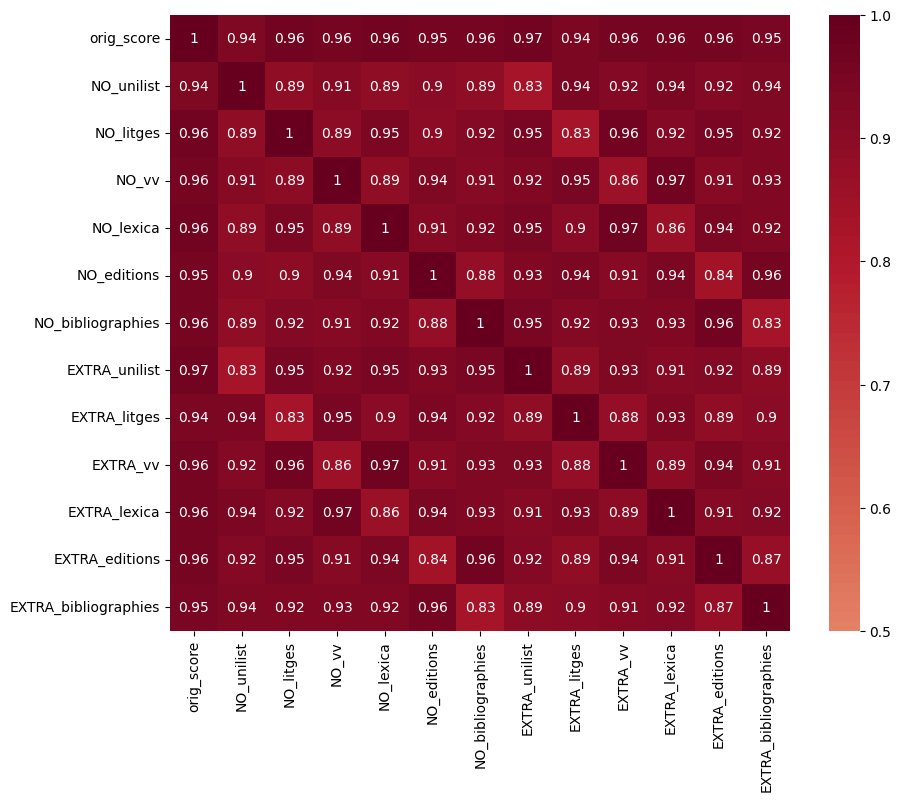

top 500 authors


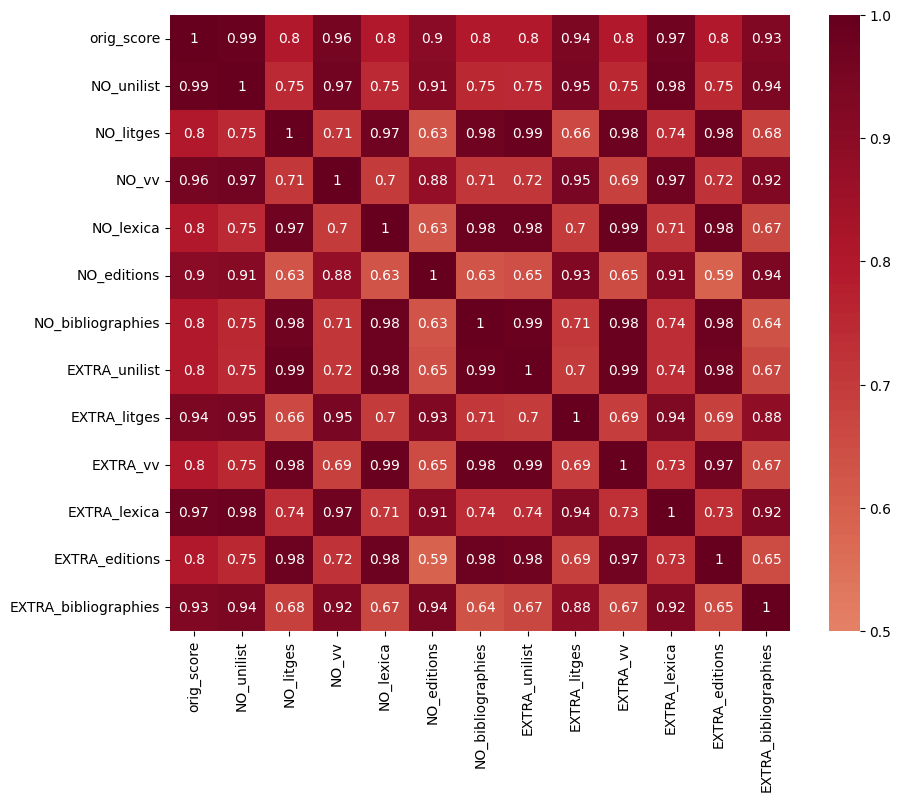

top 999999 authors


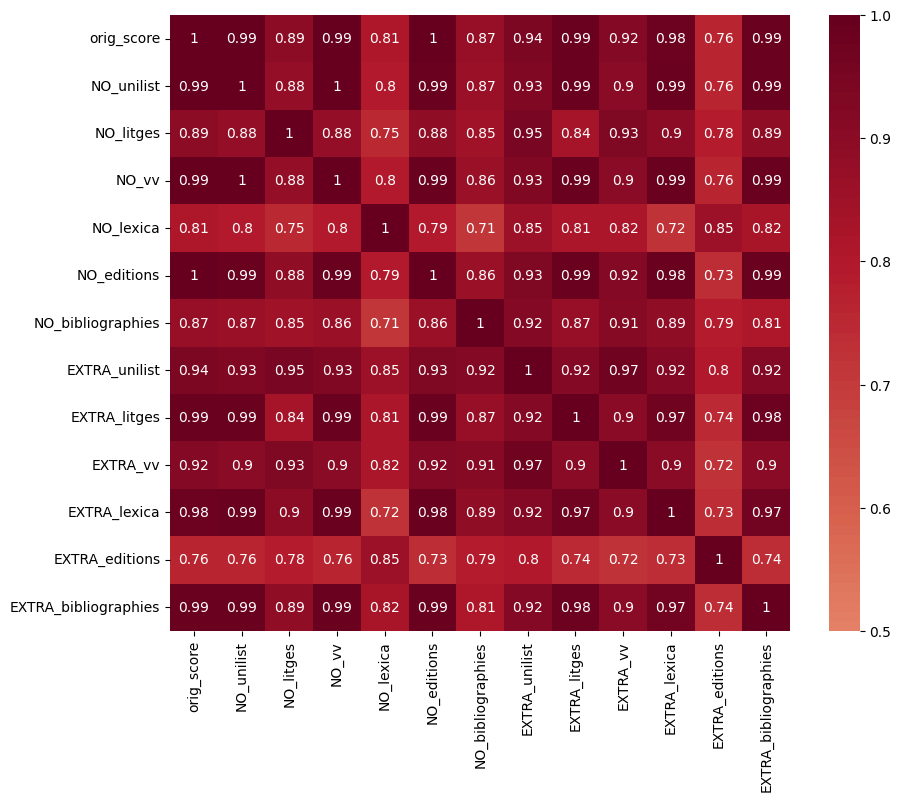

In [12]:
# weighting

robustness_data = data[['GND_name', 'canonicity_score_raw']].copy()
robustness_data = robustness_data.rename(columns={'canonicity_score_raw' : 'orig_score'})

# drop primary indicator
for prim_indicator in academic_indicator_dict.keys():
    data_temp = add_scores(
        data,
        canon_indicators = [x for x in academic_indicator_dict.keys() if x != prim_indicator]
        ).copy()
    robustness_data['NO_'+prim_indicator] = data_temp['canonicity_score_raw']
    robustness_data = robustness_data.copy()

# add additional weight to primary indicator
for prim_indicator in academic_indicator_dict.keys():
    data_temp = add_scores(
        data,
        canon_indicators = list(academic_indicator_dict.keys()) + [prim_indicator]
        ).copy()
    robustness_data['EXTRA_'+prim_indicator] = data_temp['canonicity_score_raw']
    robustness_data = robustness_data.copy()

# show results
for top in [100, 500, 999999]:
    print(f"top {top} authors")
    corr_results = robustness_data.sort_values(by='orig_score').tail(top).drop(['GND_name'], axis=1).corr(method='spearman')

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_results,
        annot=True,
        vmin=0.5, vmax=1,   # fix scale from -1 to 1
        center=0,          # optional: ensures diverging colormap is centered at 0
        cmap="RdBu_r"    # diverging colormap for negative/positive values
    )
    plt.show()

# 5.1 Vergleich der Indikatoren

In [13]:
def get_authors_for_indicator (data, primary_indicator):
    secondary_indicators = all_indicator_dict[primary_indicator]
    pos_with_indicator = (data[secondary_indicators] != 0).any(axis=1)
    data_with_indicator = data.loc[pos_with_indicator]
    indicator_gnds = data_with_indicator['GND'].tolist()

    return indicator_gnds

len(get_authors_for_indicator(data, 'abi'))

72

In [14]:
indicator_length = []

for primary_indicator in all_indicator_dict.keys():

    indicator_length.append({
        "primary_indicator": primary_indicator,
        "author_count": len(get_authors_for_indicator(data, primary_indicator)),
    })

indicator_length = pd.DataFrame(indicator_length)
display(indicator_length.sort_values(by='author_count'))

,primary_indicator,author_count
8,abi,72
9,kanonspiel,86
6,staatsexamen,105
11,vv_hein,148
4,editions,263
10,segebrecht,285
7,schullist,438
2,vv,543
0,unilist,688
1,litges,1133


## Raw Correlation

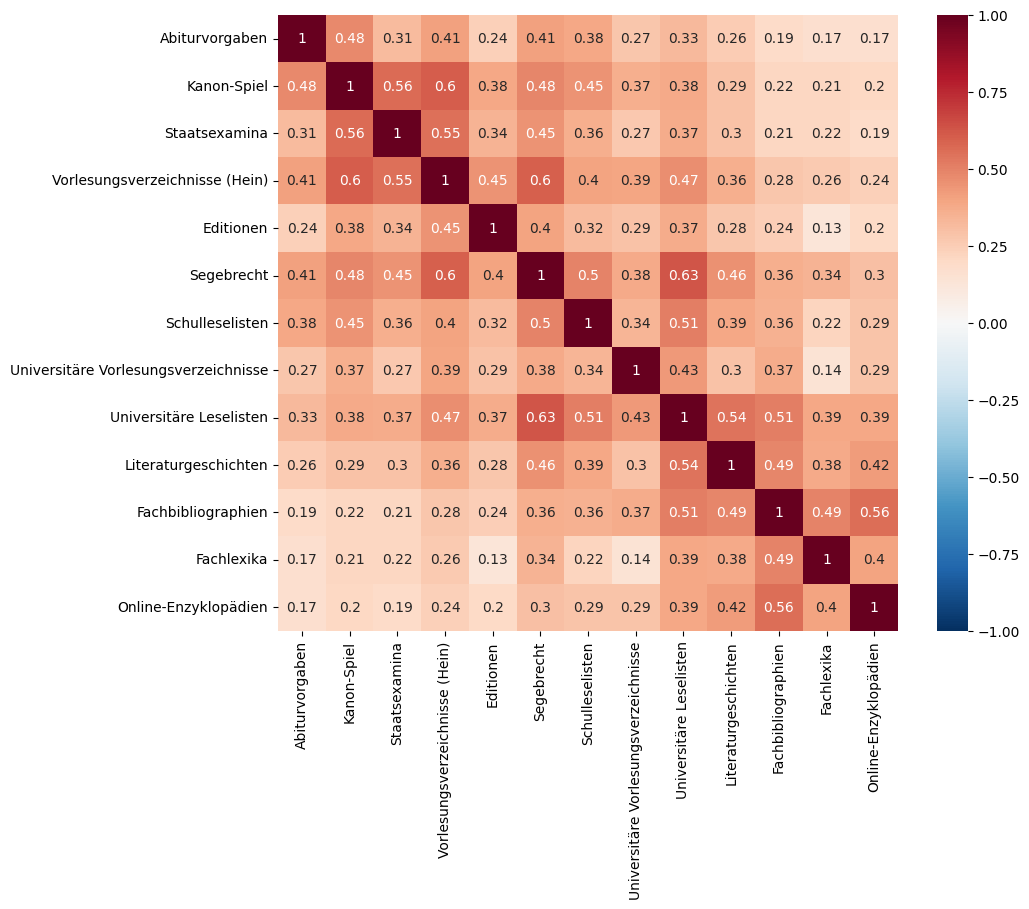

In [15]:
corr_results = data[all_indicator_dict.keys()].corr(method='spearman')

# sort columns and rows by indicator length
corr_results = corr_results.loc[indicator_length.sort_values(by='author_count')['primary_indicator']]
corr_results = corr_results[indicator_length.sort_values(by='author_count')['primary_indicator']]

# rename columns and rows
corr_results.index = [all_indicator_label_dict[x] for x in  corr_results.index]
corr_results.columns = [all_indicator_label_dict[x] for x in  corr_results.columns]

# plot results
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_results,
    annot=True,
    vmin=-1, vmax=1,   # fix scale from -1 to 1
    center=0,          # optional: ensures diverging colormap is centered at 0
    cmap="RdBu_r"    # diverging colormap for negative/positive values
)
plt.show()

In [16]:
# top 5 per primary indicator
for primary_indicator in all_indicator_dict.keys():
    data_indicator_top = data.sort_values(by=primary_indicator, ascending=False)

    print(primary_indicator)
    display(data_indicator_top.head(20)[['GND_name', primary_indicator+'_zscore']])

unilist


,GND_name,unilist_zscore
3457,"Goethe, Johann Wolfgang von",39.371558
4468,"Schiller, Friedrich",23.084807
3839,"Kleist, Heinrich von",17.141402
3072,"Brecht, Bertolt",16.332407
3968,"Lessing, Gotthold Ephraim",14.974515
3778,"Kafka, Franz",13.437419
3686,"Hofmannsthal, Hugo von",12.076676
3112,"Büchner, Georg",11.787282
4040,"Mann, Thomas",11.400907
4501,"Schnitzler, Arthur",9.717472


litges


,GND_name,litges_zscore
3072,"Brecht, Bertolt",27.379975
3457,"Goethe, Johann Wolfgang von",24.809756
4468,"Schiller, Friedrich",18.422669
4040,"Mann, Thomas",16.862473
3968,"Lessing, Gotthold Ephraim",12.220346
3599,"Heine, Heinrich",11.713789
3481,"Grass, Günter",11.210323
4867,"Wolf, Christa",10.381972
2996,"Benn, Gottfried",9.417625
4842,"Wieland, Christoph Martin",9.372980


vv


,GND_name,vv_zscore
3457,"Goethe, Johann Wolfgang von",39.074983
3072,"Brecht, Bertolt",23.064577
3778,"Kafka, Franz",22.713776
4468,"Schiller, Friedrich",19.506480
3839,"Kleist, Heinrich von",17.060418
4378,"Rilke, Rainer Maria",12.575502
3682,"Hoffmann, E. T. A.",12.168292
4040,"Mann, Thomas",11.308218
2945,"Bachmann, Ingeborg",10.040934
3968,"Lessing, Gotthold Ephraim",9.722229


lexica


,GND_name,lexica_zscore
3457,"Goethe, Johann Wolfgang von",15.578166
4468,"Schiller, Friedrich",12.963051
3072,"Brecht, Bertolt",10.924965
3677,"Hölderlin, Friedrich",10.601893
4040,"Mann, Thomas",9.161732
3839,"Kleist, Heinrich von",8.949565
3968,"Lessing, Gotthold Ephraim",8.724540
3599,"Heine, Heinrich",8.366107
3580,"Hauptmann, Gerhart",8.324316
3481,"Grass, Günter",7.879088


editions


,GND_name,editions_zscore
3457,"Goethe, Johann Wolfgang von",32.183056
4468,"Schiller, Friedrich",26.031710
3682,"Hoffmann, E. T. A.",19.880364
4501,"Schnitzler, Arthur",19.880364
3839,"Kleist, Heinrich von",17.317303
3367,"Fontane, Theodor",15.779467
3968,"Lessing, Gotthold Ephraim",12.703794
3686,"Hofmannsthal, Hugo von",12.191181
3809,"Keller, Gottfried",12.191181
3129,"Busch, Wilhelm",12.191181


bibliographies


,GND_name,bibliographies_zscore
3457,"Goethe, Johann Wolfgang von",42.032827
3778,"Kafka, Franz",19.900411
4040,"Mann, Thomas",19.628038
4468,"Schiller, Friedrich",15.880838
3839,"Kleist, Heinrich von",13.586297
4205,"Nietzsche, Friedrich",13.429476
3072,"Brecht, Bertolt",12.946632
3682,"Hoffmann, E. T. A.",12.273951
3599,"Heine, Heinrich",9.979410
3367,"Fontane, Theodor",9.649261


staatsexamen


,GND_name,staatsexamen_zscore
3457,"Goethe, Johann Wolfgang von",43.843823
3809,"Keller, Gottfried",18.744525
4040,"Mann, Thomas",17.698721
3968,"Lessing, Gotthold Ephraim",16.652917
3072,"Brecht, Bertolt",16.652917
3839,"Kleist, Heinrich von",16.652917
4468,"Schiller, Friedrich",14.561309
3112,"Büchner, Georg",13.515505
3367,"Fontane, Theodor",13.515505
3599,"Heine, Heinrich",11.423897


schullist


,GND_name,schullist_zscore
3457,"Goethe, Johann Wolfgang von",31.885983
4468,"Schiller, Friedrich",28.359877
3778,"Kafka, Franz",20.869855
3403,"Frisch, Max",14.168485
3072,"Brecht, Bertolt",14.168485
3839,"Kleist, Heinrich von",13.714555
4040,"Mann, Thomas",13.714555
3112,"Büchner, Georg",13.691837
3968,"Lessing, Gotthold Ephraim",13.691837
3268,"Dürrenmatt, Friedrich",13.238922


abi


,GND_name,abi_zscore
3457,"Goethe, Johann Wolfgang von",29.584260
3778,"Kafka, Franz",28.966607
4468,"Schiller, Friedrich",25.260685
3839,"Kleist, Heinrich von",22.790070
3112,"Büchner, Georg",20.319455
3367,"Fontane, Theodor",20.319455
3072,"Brecht, Bertolt",17.848841
3682,"Hoffmann, E. T. A.",16.613533
4040,"Mann, Thomas",15.378226
3268,"Dürrenmatt, Friedrich",13.525265


kanonspiel


,GND_name,kanonspiel_zscore
3457,"Goethe, Johann Wolfgang von",29.489768
4040,"Mann, Thomas",20.443244
3839,"Kleist, Heinrich von",19.614327
3072,"Brecht, Bertolt",19.137253
4468,"Schiller, Friedrich",19.000094
3778,"Kafka, Franz",17.610615
3648,"Hesse, Hermann",17.425749
3112,"Büchner, Georg",17.056016
3367,"Fontane, Theodor",11.688929
3682,"Hoffmann, E. T. A.",11.414611


segebrecht


,GND_name,segebrecht_zscore
3457,"Goethe, Johann Wolfgang von",33.906103
4468,"Schiller, Friedrich",22.055137
3367,"Fontane, Theodor",14.648283
4040,"Mann, Thomas",13.166912
3072,"Brecht, Bertolt",13.166912
9021,"Tieck, Ludwig",11.685541
3682,"Hoffmann, E. T. A.",11.685541
3839,"Kleist, Heinrich von",11.685541
3403,"Frisch, Max",10.204170
3968,"Lessing, Gotthold Ephraim",8.722800


vv_hein


,GND_name,vv_hein_zscore
3457,"Goethe, Johann Wolfgang von",54.288733
4040,"Mann, Thomas",18.291672
4468,"Schiller, Friedrich",16.992809
3968,"Lessing, Gotthold Ephraim",12.539564
3072,"Brecht, Bertolt",10.684045
3677,"Hölderlin, Friedrich",10.498493
3839,"Kleist, Heinrich von",10.312942
3599,"Heine, Heinrich",10.127390
3778,"Kafka, Franz",9.385182
3367,"Fontane, Theodor",8.642975


wiki


,GND_name,wiki_zscore
3457,"Goethe, Johann Wolfgang von",16.697998
3599,"Heine, Heinrich",12.060923
5060,"Blüher, Hans",9.142022
3778,"Kafka, Franz",9.000899
4626,"Storm, Theodor",8.878783
3809,"Keller, Gottfried",8.522889
4692,"Tönnies, Ferdinand",8.306692
4019,"Luserke, Martin",8.304316
3367,"Fontane, Theodor",8.252049
3129,"Busch, Wilhelm",8.160818


## Intersection Correlation

In [17]:
corr_table = []

for primary_indicator_a in list(all_indicator_dict.keys()):
    authors_a = get_authors_for_indicator(data, primary_indicator_a)

    for primary_indicator_b in list(all_indicator_dict.keys()):
        if primary_indicator_a == primary_indicator_b:
            continue

        authors_b = get_authors_for_indicator(data, primary_indicator_b)
        authors_intersect = list(set(authors_a) & set(authors_b))
        data_intersect = (
            data
            .query("GND.isin(@authors_intersect)")
            .copy()
            .pipe(add_scores)
        )

        this_results = {
            'indicator_a' : primary_indicator_a,
            'indicator_b' : primary_indicator_b,

            'len_a' : len(authors_a),
            'len_b' : len(authors_b),
            'len_diff' : abs(len(authors_a)-len(authors_b)),
            'len_intersect' : len(authors_intersect),

            'corr' : data[[primary_indicator_a, primary_indicator_b]].corr(method='spearman').iloc[0,1],
            'corr_intersect' : data_intersect[[primary_indicator_a, primary_indicator_b]].corr(method='spearman').iloc[0,1],
        }
        corr_table.append(this_results)

corr_table = pd.DataFrame(corr_table)

In [18]:
display(corr_table.head())
display(corr_table[['len_diff', 'corr', 'corr_intersect']].corr(method='spearman'))

,indicator_a,indicator_b,len_a,len_b,len_diff,len_intersect,corr,corr_intersect
0,unilist,litges,688,1133,445,502,0.543396,0.613823
1,unilist,vv,688,543,145,294,0.432320,0.617929
2,unilist,lexica,688,4746,4058,633,0.387358,0.592102
3,unilist,editions,688,263,425,163,0.371877,0.617471
4,unilist,bibliographies,688,3970,3282,684,0.508748,0.706639


,len_diff,corr,corr_intersect
len_diff,1.000000,-0.651892,-0.252545
corr,-0.651892,1.000000,0.341292
corr_intersect,-0.252545,0.341292,1.000000


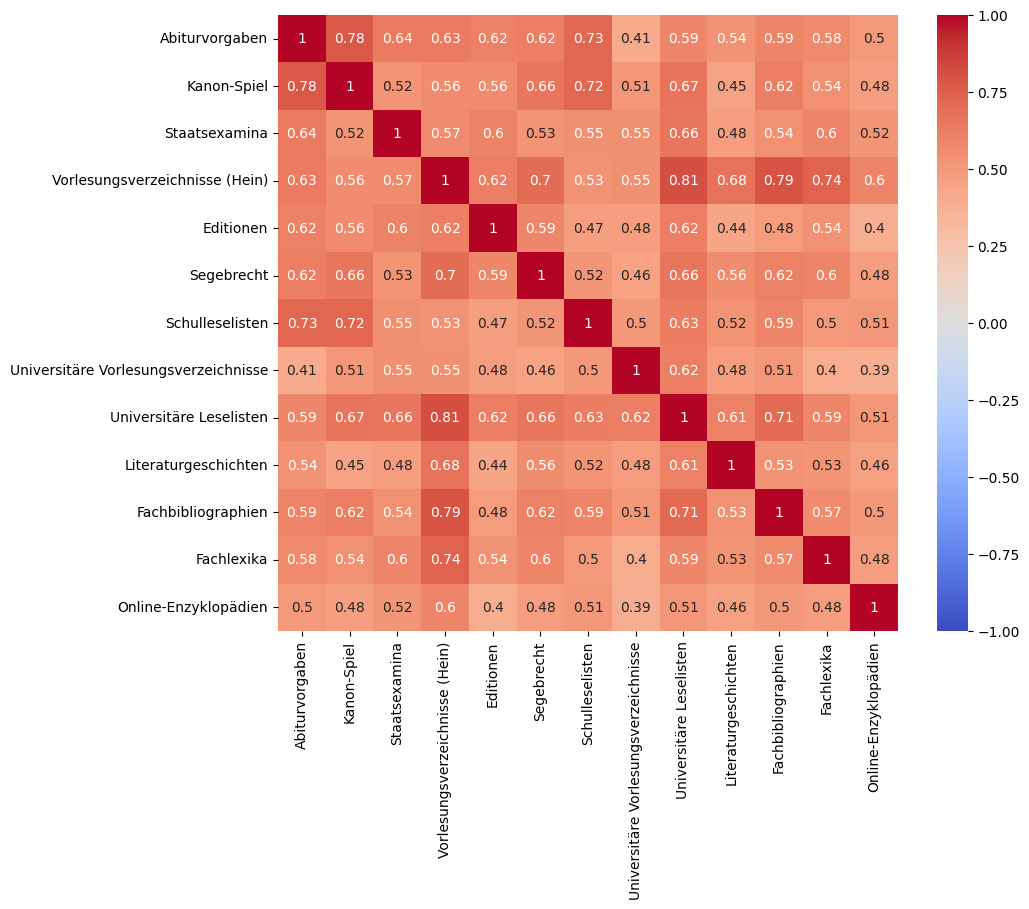

In [19]:
indicators = corr_table.sort_values(by='len_a', ascending=True)['indicator_a'].unique()

heatmap_corr_intersect = pd.DataFrame()
for indicator_a in indicators:
    for indicator_b in indicators:
        if indicator_a == indicator_b:
            heatmap_corr_intersect.at[indicator_a, indicator_b] = 1
        else:
            heatmap_corr_intersect.at[indicator_a, indicator_b] = (
                corr_table
                .query("indicator_a==@indicator_a and indicator_b==@indicator_b")
                ['corr_intersect']
                .tolist()[0]
            )

# rename columns and rows
heatmap_corr_intersect.index = [all_indicator_label_dict[x] for x in  heatmap_corr_intersect.index]
heatmap_corr_intersect.columns = [all_indicator_label_dict[x] for x in  heatmap_corr_intersect.columns]

# plot results 
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_corr_intersect,
    annot=True,
    vmin=-1, vmax=1,   # fix scale from -1 to 1
    center=0,          # optional: ensures diverging colormap is centered at 0
    cmap="coolwarm"    # diverging colormap for negative/positive values
)
plt.show()

# 5.2 Gesamtscore

In [20]:
data.sort_values(by='canonicity_score_raw', ascending=False)[[
    'GND', 'GND_name',
    'canonicity_score_rank', 'canonicity_score_scaled', 'canonicity_score_raw',
]].reset_index(drop=True).head(50)

,GND,GND_name,canonicity_score_rank,canonicity_score_scaled,canonicity_score_raw
0,118540238,"Goethe, Johann Wolfgang von",1,1000.000000,35.629020
1,118607626,"Schiller, Friedrich",2,534.602790,18.964574
2,118563076,"Kleist, Heinrich von",3,432.912493,15.323357
3,118514768,"Brecht, Bertolt",4,413.814569,14.639519
4,118577166,"Mann, Thomas",5,322.073766,11.354563
5,118559230,"Kafka, Franz",6,312.734649,11.020158
6,118572121,"Lessing, Gotthold Ephraim",7,311.369833,10.971288
7,118552465,"Hoffmann, E. T. A.",8,293.411253,10.328246
8,118548018,"Heine, Heinrich",9,266.832151,9.376530
9,118552759,"Hofmannsthal, Hugo von",10,222.383871,7.784974


In [21]:
authors_of_interest = ['Fontane, Theodor', 'Storm, Theodor', 'Bachmann, Ingeborg', 'Wolf, Christa', 'Heym, Georg', 'Trakl, Georg']

data.query("GND_name.isin(@authors_of_interest)").sort_values(by='canonicity_score_raw', ascending=False)[[
    'GND', 'GND_name',
    'canonicity_score_rank', 'canonicity_score_scaled', 'canonicity_score_raw',
]].reset_index(drop=True)

,GND,GND_name,canonicity_score_rank,canonicity_score_scaled,canonicity_score_raw
0,118534262,"Fontane, Theodor",11,218.084257,7.631018
1,118505602,"Bachmann, Ingeborg",23,141.658744,4.894455
2,118634666,"Wolf, Christa",30,125.707688,4.323296
3,118618725,"Storm, Theodor",34,109.089124,3.728237
4,118623575,"Trakl, Georg",79,49.270435,1.586313
5,118550683,"Heym, Georg",103,34.064331,1.041829


In [22]:
# female_share
top = 200

data_top = data.sort_values(by='canonicity_score_raw', ascending=False).head(top)
male_count = data_top.query("GND_gender == 'Männlich'").shape[0]
female_count = data_top.query("GND_gender == 'Weiblich'").shape[0]

print(f"Betrachtete Autor:innen : {top}")
print(f"... davon Männer        : {male_count}")
print(f"... davon Frauen        : {female_count}")

Betrachtete Autor:innen : 200
... davon Männer        : 171
... davon Frauen        : 29


# 5.3 Wie groß ist der aktuelle akademische Kanon?

In [23]:
top = 500

## Preparation

In [24]:
authors_ranked = (
    data
    .sort_values(by='canonicity_score_raw', ascending=False)
    [['GND', 'GND_name', 
      'canonicity_score_rank', 'canonicity_score_rank_cont', 
      'canonicity_score_scaled', 'canonicity_score_raw', 'canonicity_score_relcount']]
    .reset_index(drop=True)
    .head(top)
    .copy()
)

authors_ranked['canonicity_score_scaled_next'] = authors_ranked['canonicity_score_scaled'].shift(-1)

authors_ranked['canonicity_drop'] = authors_ranked['canonicity_score_scaled']-authors_ranked['canonicity_score_scaled_next']
authors_ranked['canonicity_drop_rel'] = authors_ranked['canonicity_drop']/authors_ranked['canonicity_score_scaled']
authors_ranked['canonicity_drop_rel_window'] = authors_ranked['canonicity_drop_rel'].rolling(window=10, center=True).mean()

In [25]:
authors_ranked.head()

,GND,GND_name,canonicity_score_rank,canonicity_score_rank_cont,canonicity_score_scaled,canonicity_score_raw,canonicity_score_relcount,canonicity_score_scaled_next,canonicity_drop,canonicity_drop_rel,canonicity_drop_rel_window
0,118540238,"Goethe, Johann Wolfgang von",1,1,1000.000000,35.629020,6,534.602790,465.397210,0.465397,NaN
1,118607626,"Schiller, Friedrich",2,2,534.602790,18.964574,6,432.912493,101.690297,0.190217,NaN
2,118563076,"Kleist, Heinrich von",3,3,432.912493,15.323357,6,413.814569,19.097923,0.044115,NaN
3,118514768,"Brecht, Bertolt",4,4,413.814569,14.639519,5,322.073766,91.740803,0.221695,NaN
4,118577166,"Mann, Thomas",5,5,322.073766,11.354563,6,312.734649,9.339117,0.028997,NaN


## Plot Distribution

In [26]:
fig = px.bar(
    authors_ranked,
    x = 'canonicity_score_rank_cont',
    y = 'canonicity_score_scaled'
)
fig.update_layout(
    xaxis=dict(
        showticklabels=True,
        title="Rang"
    ),
    yaxis=dict(
        title="Gesamtscore"
    )
)
fig.update_traces(
    width=2,
    marker=dict(line=dict(width=0))
)
fig.show()

In [27]:
fig = px.bar(
    authors_ranked.head(100),
    x = 'canonicity_score_rank_cont',
    y = 'canonicity_score_scaled'
)
fig.update_layout(
    xaxis=dict(
        showticklabels=True,
        title="Rang"
    ),
    yaxis=dict(
        title="Gesamtscore"
    )
)

fig.show()

## Percentage Drop

In [28]:
authors_ranked.sort_values(by='canonicity_drop_rel', ascending=False).head(10)[[
    'GND_name', 
    'canonicity_score_rank', 'canonicity_score_scaled',
    'canonicity_score_scaled_next',
    'canonicity_drop_rel'
]]

,GND_name,canonicity_score_rank,canonicity_score_scaled,canonicity_score_scaled_next,canonicity_drop_rel
0,"Goethe, Johann Wolfgang von",1,1000.000000,534.602790,0.465397
3,"Brecht, Bertolt",4,413.814569,322.073766,0.221695
1,"Schiller, Friedrich",2,534.602790,432.912493,0.190217
8,"Heine, Heinrich",9,266.832151,222.383871,0.166578
7,"Hoffmann, E. T. A.",8,293.411253,266.832151,0.090587
11,"Hölderlin, Friedrich",12,203.619030,187.016607,0.081537
10,"Fontane, Theodor",11,218.084257,203.619030,0.066329
113,"Grabbe, Christian Dietrich",114,27.705751,25.868660,0.066307
27,"Wieland, Christoph Martin",28,135.652800,127.021923,0.063625
56,"Müller, Heiner",57,76.154998,71.391039,0.062556


In [29]:
px.bar(
    authors_ranked.head(100),
    x = 'canonicity_score_rank',
    y = ['canonicity_drop_rel', 'canonicity_drop_rel_window'],
    barmode='group',
    hover_name='GND_name'
)

## Expected vs. Observed Drop

In [30]:
def power_law_rank(rank, a, b):
    return a * rank ** (-b)

ranks = authors_ranked['canonicity_score_rank_cont'].values
scores = authors_ranked['canonicity_score_scaled'].values

popt, _ = curve_fit(power_law_rank, ranks, scores)
predicted_scores = power_law_rank(ranks, *popt)
print(f"Fitted function: score = {popt[0]:.4f} * rank^(-{popt[1]:.4f})")

authors_ranked['canonicity_score_scaled_predicted'] = predicted_scores
authors_ranked['canonicity_score_scaled_next_predicted'] = authors_ranked['canonicity_score_scaled_predicted'].shift(-1)

authors_ranked['canonicity_drop_predicted'] = abs(authors_ranked['canonicity_score_scaled_next_predicted']-authors_ranked['canonicity_score_scaled_predicted'])
authors_ranked['canonicity_drop_rel_predicted'] = 1-(authors_ranked['canonicity_score_scaled_next_predicted']/authors_ranked['canonicity_score_scaled_predicted'])

authors_ranked['delta_drop'] = authors_ranked['canonicity_drop_rel']/authors_ranked['canonicity_drop_rel_predicted']
authors_ranked['delta_drop_window'] = authors_ranked['delta_drop'].rolling(window=10, center=True).mean()

Fitted function: score = 1024.4123 * rank^(-0.7073)


In [31]:
px.line(
    authors_ranked,
    x = 'canonicity_score_rank',
    y = ['canonicity_score_scaled', 'canonicity_score_scaled_predicted']
)

In [32]:
plot_df = authors_ranked.head(100).rename(
    columns={
        'canonicity_drop_rel': 'beobachtet',
        'canonicity_drop_rel_predicted': 'erwartet'
    }
)

fig = px.bar(
    plot_df, 
    x='canonicity_score_rank', 
    y=['beobachtet', 'erwartet'], 
    barmode='group',
    hover_data=['GND_name']
)
fig.update_layout(
    xaxis=dict(
        showticklabels=True,
        title="Rang"
    ),
    yaxis=dict(
        title="Prozentabnahme"
    ),
    legend_title_text=''   # removes legend title
)
fig.show()

In [33]:
authors_ranked.sort_values(by='delta_drop', ascending=False).head(10)[[
    'GND_name', 'canonicity_score_rank',
    'canonicity_score_scaled', 'canonicity_score_scaled_next', 'canonicity_drop_rel',
    'canonicity_score_scaled_predicted', 'canonicity_score_scaled_next_predicted', 'canonicity_drop_rel_predicted',
    'delta_drop'
]]

,GND_name,canonicity_score_rank,canonicity_score_scaled,canonicity_score_scaled_next,canonicity_drop_rel,canonicity_score_scaled_predicted,canonicity_score_scaled_next_predicted,canonicity_drop_rel_predicted,delta_drop
113,"Grabbe, Christian Dietrich",114,27.705751,25.868660,0.066307,35.944125,35.722771,0.006158,10.767155
229,"Claudius, Matthias",230,9.703416,9.388515,0.032453,21.878972,21.811938,0.003064,10.592103
284,"Süskind, Patrick",285,7.361580,7.175758,0.025242,18.800324,18.753805,0.002474,10.201550
404,"Stramm, August",405,4.281924,4.206365,0.017646,14.663049,14.637495,0.001743,10.125448
156,"Schwitters, Kurt",156,16.968478,16.271024,0.041103,28.662695,28.534265,0.004481,9.173257
444,"Weinheber, Josef",444,3.526258,3.477756,0.013754,13.718045,13.696283,0.001586,8.670211
111,"Rühmkorf, Peter",112,29.895539,28.277889,0.054110,36.396934,36.168819,0.006267,8.633550
333,"Loher, Dea",334,5.834584,5.732578,0.017483,16.804720,16.769224,0.002112,8.276923
433,"Breitbach, Joseph",434,3.699138,3.650355,0.013188,13.963066,13.940354,0.001627,8.107851
431,"Schlesinger, Klaus",431,3.756765,3.707982,0.012985,14.008757,13.985866,0.001634,7.946763


In [34]:
px.bar(
    authors_ranked.head(100),
    x = 'canonicity_score_rank',
    y = ['delta_drop', 'delta_drop_window'],
    barmode='group',
    hover_name='GND_name'
)

## Change Point Detection

In [35]:
model = "rbf"
penalty_values = range(1, 100, 1)

scores = (
    authors_ranked
    ['canonicity_score_scaled']
    .to_numpy()
)

In [36]:
results = {}
for pen in penalty_values:
    algo = rpt.Pelt(model=model, min_size=1, jump=1).fit(scores)
    result = algo.predict(pen=pen)
    results[pen] = result
    if len(result) == 1:
        break

    print(f"pen           : {pen}")
    print(f"results       : {result}")
    print(f"n breakpoints : {len(result)}")
    print(f"\n")
results_cleaned = {x : results[x] for x in results if len(results[x]) > 1}

pen           : 1
results       : [2, 4, 7, 9, 11, 12, 15, 17, 20, 28, 33, 36, 43, 46, 56, 63, 72, 80, 90, 105, 114, 132, 155, 178, 226, 285, 371, 500]
n breakpoints : 28


pen           : 2
results       : [12, 17, 20, 28, 33, 39, 46, 57, 72, 80, 90, 105, 114, 132, 157, 191, 268, 362, 500]
n breakpoints : 19


pen           : 3
results       : [20, 28, 33, 46, 57, 72, 90, 113, 143, 178, 251, 351, 500]
n breakpoints : 13


pen           : 4
results       : [20, 28, 33, 46, 57, 72, 90, 113, 146, 190, 293, 500]
n breakpoints : 12


pen           : 5
results       : [33, 46, 57, 72, 90, 113, 146, 190, 293, 500]
n breakpoints : 10


pen           : 6
results       : [33, 46, 57, 72, 90, 113, 146, 190, 293, 500]
n breakpoints : 10


pen           : 7
results       : [35, 57, 72, 90, 114, 173, 285, 500]
n breakpoints : 8


pen           : 8
results       : [35, 57, 72, 90, 114, 173, 285, 500]
n breakpoints : 8


pen           : 9
results       : [56, 72, 90, 114, 173, 285, 500]
n breakpoints

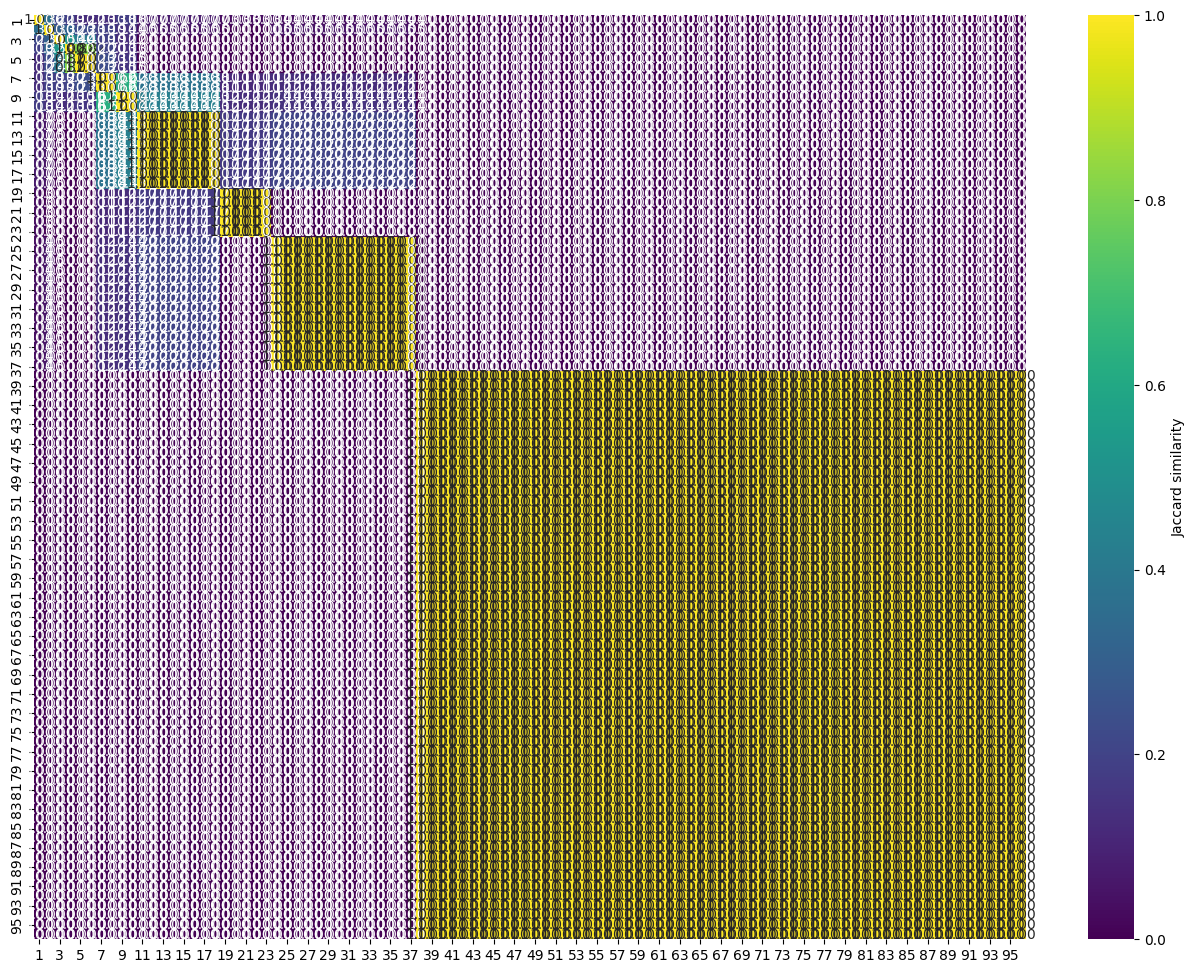

overall mean : 0.41859958681577253



In [37]:
def jaccard_similarity(set1, set2):
    set1 = set(set1)
    set2 = set(set2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

jaccard_similarities = pd.DataFrame()
for pen_1 in results_cleaned:
    pen_1_values = results_cleaned[pen_1][:-1] # exclude final endpoint
    for pen_2 in results_cleaned:
        pen_2_values = results_cleaned[pen_2][:-1] # exclude final endpoint
        jaccard_similarities.at[pen_1, pen_2] = jaccard_similarity(pen_1_values, pen_2_values)

plt.figure(figsize=(16,12))
sns.heatmap(
    jaccard_similarities.astype(float),
    annot=True, fmt=".2f",
    cmap="viridis",
    cbar_kws={'label': 'Jaccard similarity'}
)
plt.show()

mask = np.ones(jaccard_similarities.shape, dtype=bool)
np.fill_diagonal(mask, False)
off_diagonal_mean = jaccard_similarities.values[mask].mean()
print(f"overall mean : {off_diagonal_mean}\n")

In [38]:
all_values = [item for sublist in results.values() for item in sublist]
vc = pd.Series(all_values).value_counts()
print((vc/len(results)).head(10))

500    1.000000
174    0.608247
114    0.288660
285    0.185567
195    0.144330
173    0.123711
72     0.103093
90     0.103093
75     0.082474
57     0.072165
Name: count, dtype: float64


# 5.4 Exemplarische Analysen: de La Motte-Fouqué und Günderrode

In [39]:
authors_of_interest = [
    'Brecht, Bertolt', 'Toller, Ernst',
    'Günderode, Karoline von', 'Fouqué, Friedrich de La Motte-',
    'Handke, Peter', 'Tieck, Ludwig'
]

data.query("GND_name.isin(@authors_of_interest)").sort_values(by='canonicity_score_raw', ascending=False)[[
    'GND', 'GND_name',
    'canonicity_score_rank', 'canonicity_score_scaled', 'canonicity_score_raw',
]].reset_index(drop=True)

,GND,GND_name,canonicity_score_rank,canonicity_score_scaled,canonicity_score_raw
0,118514768,"Brecht, Bertolt",4,413.814569,14.639519
1,118545574,"Handke, Peter",18,159.818362,5.544695
2,12989432X,"Tieck, Ludwig",19,159.781633,5.543380
3,118623230,"Toller, Ernst",88,43.534079,1.380912
4,118543202,"Günderode, Karoline von",118,24.665354,0.705281
5,118534556,"Fouqué, Friedrich de La Motte-",129,22.039848,0.611269


In [40]:
def get_author_info (author):
    data_author = data.query("GND_name == @author").copy()

    results = {
        'GND_name' : data_author['GND_name'].values[0],
        'bdsl_hits' : data_author['BDSL_hits_2000_all'].values[0],
        'killy_length' : data_author['killy_length'].values[0],
        'pages_litges' : data_author[['page_count_litges_beutin', 'page_count_litges_brenner']].sum().sum(),
        'unilist_prob_to_read' : data_author[[x for x in data_author.columns if 'prob_to_read_sum' in x]].sum().sum(),
        'vv_sum' : data_author[['event_count_vv_mainz', 'event_count_vv_stuttgart', 'event_count_vv_wien']].sum().sum(),
        'reclam_count' : data_author['reclam_count'].values[0],
    }
    
    return results

author_data = [
    get_author_info('Fouqué, Friedrich de La Motte-'),
    get_author_info('Günderode, Karoline von'),
]
pd.DataFrame(author_data).set_index('GND_name').T

GND_name,"Fouqué, Friedrich de La Motte-","Günderode, Karoline von"
bdsl_hits,138.000000,117.000000
killy_length,2156.000000,1417.000000
pages_litges,4.000000,5.000000
unilist_prob_to_read,5.526429,16.771027
vv_sum,2.000000,4.000000
reclam_count,2.000000,1.000000
